In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator

data = pd.read_csv('../input/netflix-shows/netflix_titles.csv')
ratings = pd.read_csv('../input/imdb-ratings-for-the-netflix-shows/IMDB_results_jan-28-2020.csv')
data = data.fillna('Unknown')
data.drop(['show_id','date_added'], axis=1, inplace=True)

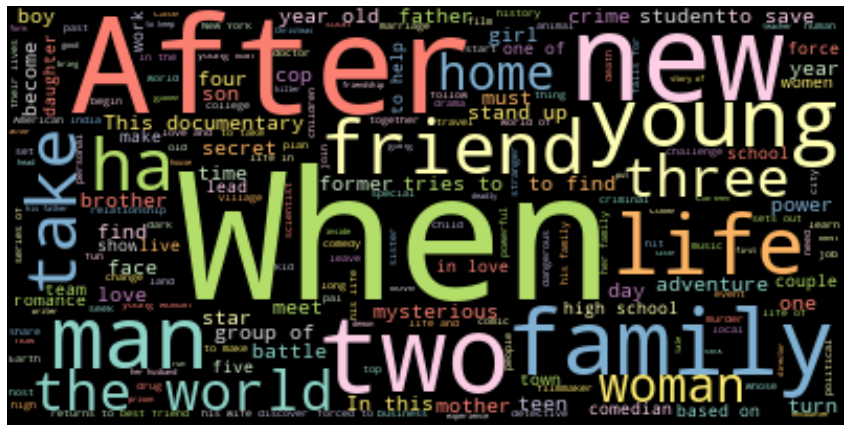

In [2]:
text = " ".join(review for review in data.description)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

# Which year is most shows released? ---> 2018

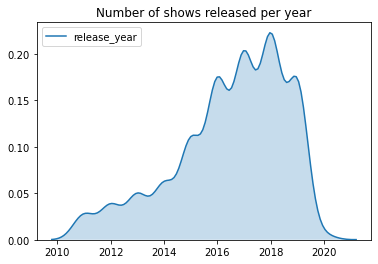

In [3]:
df = data[data['release_year']>2010]
sns.kdeplot(data=df['release_year'], label='release_year', shade=True)
plt.title('Number of shows released per year')
plt.show()

A major problem with this dataset is there is no metric on which I can compare other variables.

I just found a dataset with the IMDB ratings of the shows in this dataset from a separate script.

Script that produced the dataset: https://www.kaggle.com/aalhendi/netflix-movies-and-tv-shows-ratings

In [4]:
data['IMDB_rating'] = ratings['IMDB_rating'].str.split().str[0].str.replace('Not','0.0')
data['Number of reviews'] = ratings['IMDB_rating'].str.split().str[3].str.replace(',','')
data['IMDB_rating'] = data['IMDB_rating'].astype('float')
data['Number of reviews'] = data['Number of reviews'].dropna().astype('int')
data = data.dropna()

I almost dropped a 100 columns, this wouldn't have been a good choice for using the data for finding patterns in it or applying ML models but since I am only doing analysis of the columns, it's better to drop them.

# Shows/movie with all time highest reviews ---> Inception

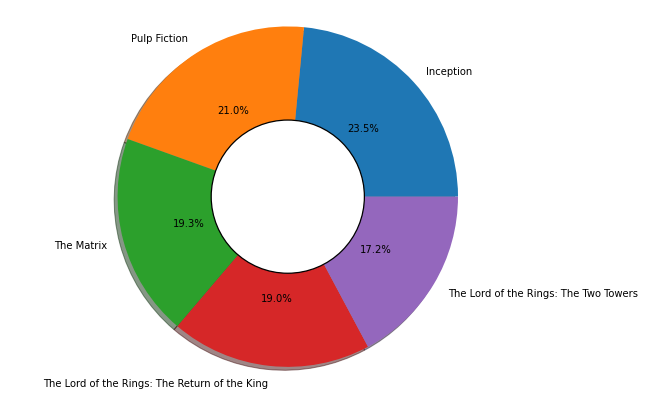

In [5]:
df = data.sort_values('Number of reviews', ascending=False)
df = df.head()

fig = plt.figure(figsize=(10,7))
plt.pie(df['Number of reviews'], labels=df['title'], autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.45,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

# IMDB Rating distribution ---> Highest density at 7

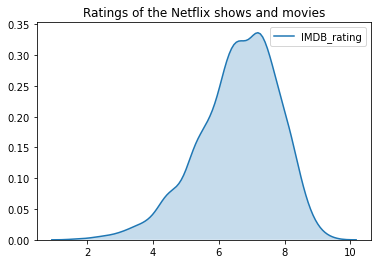

In [6]:
sns.kdeplot(data=data['IMDB_rating'], label='IMDB_rating', shade=True)
plt.title('Ratings of the Netflix shows and movies')
plt.show()

# Movie with all time highest rating ---> 
# My next guest with David Letterman and Shah Rukh Khan

In [7]:
movie = data[data['type']=='Movie']
movie = movie.sort_values('IMDB_rating')
movie = movie.tail()

fig = px.pie(movie, names='title', values='IMDB_rating', template='seaborn')
fig.update_traces(rotation=90, pull=[0.03,0.03,0.03,0.03,0.2], textinfo="percent+label")
fig.show()

# TV Show with all time highest rating ---> Breaking Bad

In [8]:
show = data[data['type']=='TV Show']
show = show.sort_values('IMDB_rating')
show = show.tail()

fig = px.pie(show, names='title', values='IMDB_rating', template='seaborn')
fig.update_traces(rotation=90, pull=[0.03,0.03,0.03,0.03,0.2], textinfo="percent+label")
fig.show()

# Average rating of top 5 genres

In [9]:
top_5_genres = ['Stand-Up Comedy','Documentaries','Dramas, International Movies','Comedies, Dramas, International Movies',"Kids' TV"]
perc = data.loc[:,["release_year","listed_in",'IMDB_rating']]
perc['mean_rating'] = perc.groupby([perc.listed_in,perc.release_year])['IMDB_rating'].transform('mean')
perc.drop('IMDB_rating', axis=1, inplace=True)
perc = perc.drop_duplicates()
perc = perc[(perc.release_year>2009) & (perc.release_year<2020)]
perc = perc.loc[perc['listed_in'].isin(top_5_genres)]
perc = perc.sort_values("release_year")

fig=px.bar(perc,x='listed_in', y="mean_rating", animation_frame="release_year", 
           animation_group="listed_in", color="listed_in", hover_name="listed_in", range_y=[0,10])
fig.update_layout(showlegend=False)
fig.show()

# Meanings of each rating

1. TV-MA - This program is specifically designed to be viewed by adults and therefore may be unsuitable for children under 17
2. TV-14 - This program contains some material that many parents would find unsuitable for children under 14 years of age
3. TV-PG - This program contains material that parents may find unsuitable for younger children
4. R     - Under 17 requires accompanying parent or adult guardian
5. PG-13 - Some material may be inappropriate for children under 13
6. NR    - Not rated
7. PG    - Some material may not be suitable for children
8. TV-Y7 - This program is designed for children age 7 and above
9. TV-G  - This program is suitable for all ages
10. TV-Y - This program is designed to be appropriate for all children
11. TV-Y7-FV - This program is designed for children age 7 and above containing some fantasy violence
12. G    - All ages admitted
13. UR   - Unrated
14. NC-17- No One 17 and Under Admitted

# Which rate got the highest number of reviews? ---> NC-17

In [10]:
rate = data.loc[:,['rating','Number of reviews']]
rate['mean_num_of_reviews'] = rate.groupby('rating')['Number of reviews'].transform('mean')
rate.drop('Number of reviews', axis=1, inplace=True)
rate = rate.drop_duplicates().sort_values('mean_num_of_reviews')
rate = rate.tail()

fig = px.pie(rate, names='rating', values='mean_num_of_reviews', template='seaborn')
fig.update_traces(rotation=90, pull=[0.03,0.03,0.03,0.03,0.2], textinfo="percent+label")
fig.show()

Now by definition NC-17 means no one under age of 17 should be admitted. So a large audience is already cut out for this rating.

But still this rating managed to get the highest number of reviews. Need to dig more into it to understand the reason behind this.

# IMDB ratings comparison of movies and TV shows

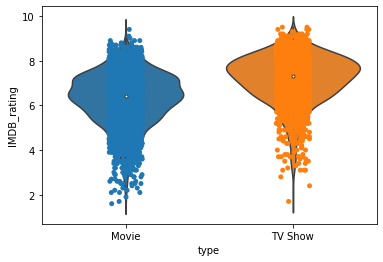

In [11]:
ax = sns.stripplot(x="type", y="IMDB_rating", data=data)
ax = sns.violinplot(x="type", y="IMDB_rating", data=data)

# Directors of top 5 movie/shows with highest rating

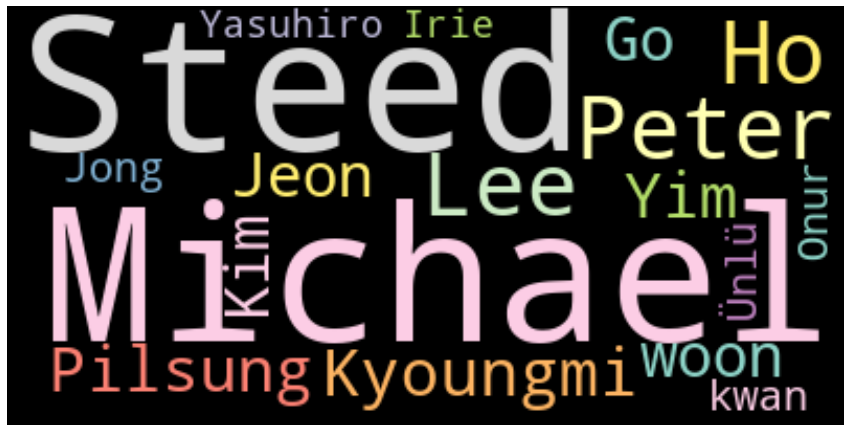

In [12]:
directors = data[data['director']!='Unknown']
directors = directors.sort_values('IMDB_rating', ascending=False)
directors = directors.head()

text = ",".join(review for review in directors.director)
wordcloud = WordCloud(max_words=200, colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

# Duration of the highest rated movies ---> 61 minutes

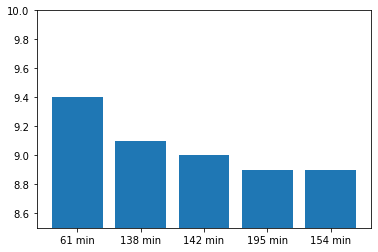

In [13]:
movie = data.loc[data['type']=='Movie', ['duration','IMDB_rating']]
movie = movie.sort_values('IMDB_rating', ascending=False)
movie = movie.head()

plt.bar(x=movie['duration'], height=movie['IMDB_rating'])
plt.ylim(8.5, 10)
plt.show()

# Duration of the highest rated TV shows ---> (1/5) seasons

In [14]:
show = data.loc[data['type']=='TV Show', ['duration','IMDB_rating']]
show['IMDB_rating'] = show.groupby('duration')['IMDB_rating'].transform('max')
show = show.drop_duplicates()
show = show.sort_values('IMDB_rating', ascending=False)
show = show.head(5)

fig = px.pie(show, names='duration', values='IMDB_rating', template='seaborn')
fig.update_traces(rotation=90, pull=[0.1,0.03,0.03,0.03,0.03], textinfo="percent+label")
fig.show()

# Distribution of Number of Reviews

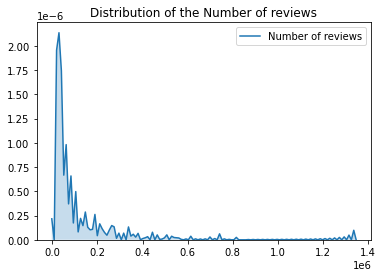

In [15]:
df = data[data['release_year']>2010]
sns.kdeplot(data=df['Number of reviews'], label='Number of reviews', shade=True)
plt.title('Distribution of the Number of reviews')
plt.show()

# Where is the highest rated movie made? ---> United Kingdom

In [16]:
country = data.loc[data['type']=='Movie', ['country','IMDB_rating']]
country['IMDB_rating'] = country.groupby('country')['IMDB_rating'].transform('max')
country = country.drop_duplicates()
country = country.sort_values('IMDB_rating', ascending=False)
country = country[1:6]

fig = px.pie(country, names='country', values='IMDB_rating', template='seaborn')
fig.update_traces(rotation=90, pull=[0.1,0.03,0.03,0.03,0.03], textinfo="percent+label")
fig.show()

# Cast members of the highest rated movie

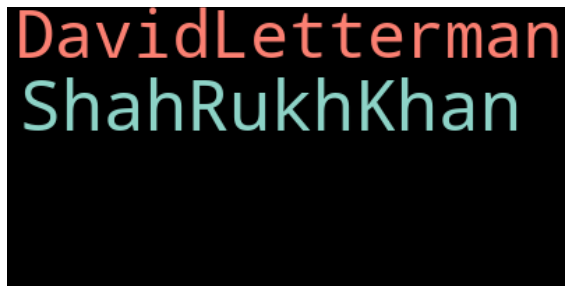

In [17]:
movie = data[data['type']=='Movie']
movie = movie.sort_values('IMDB_rating')
movie = movie.tail(1)
text = 'ShahRukhKhan DavidLetterman'
wordcloud = WordCloud(colormap='Set3',background_color="black").generate(text)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()